# Project Idea
* The idea of the project is to keep the robot from the wall with static distance to replace PID method.
* <a href=https://en.wikipedia.org/wiki/PID_controller>Proportional–Integral–Derivative controller</a> is one of the method used for it but it need manual modification to get the constant variables.
* Here we let the machine learn by it self and decide the required speed depending on the position.
* (The algorithm Control specific region around the optimal distance only) other wise it might stuck far away from the wanted distance trying random actions.

# Robot behavior Simulater

<b>The simulator created to minimze battery consumption on the real robot, used for testing and preparing code</b>
<b> Code in :Rob.py</b>

In [1]:
import numpy as np
from time import sleep
import sys

%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(1377)

# Due to Battery Limitation Robot Simulator Created in Rob.py
* We interact with the robot using fwd,bwd,speed only
* the robot feed back is it's distance from the wall

In [2]:
from Rob import Robot

# Reinforcement Learning Model
* Sarsa

In [3]:
from RL_Controller_Sarsa import RL_Controller_Sarsa

## Function to Draw Best speed vs Current State

In [4]:
def Draw(main,text,ax):
    lst=[]
    for i in range(main.qsa.shape[0]):
        lst.append((main.States[i,0],main.actions[np.argmax(main.qsa[i])]))
    lst=lst[1:len(lst)-1]
    allinfo = np.array(lst)
    ax.plot(allinfo[:,0],allinfo[:,1])
    ax.title(text)

## Function to Draw each 1000 episode for 19,000 in total

In [5]:
def CalculateForSpecificLambda(lmbda):
    fig = plt.figure(1,figsize=(40, 10))
    #Initialization
    main = RL_Controller_Sarsa(lmbda=lmbda,optimal_distance=30,actionscount=10,StatesCount=100)
    main.Initalization()
    plt.subplot(4,5,1)
    Draw(main,'When Initalized',plt)
    episodesperloop=1000
    for i in range (1,20):
        main.PlaySarasa(episodesperloop)
        print 'Total Episodes :{}'.format(i*episodesperloop)
        plt.subplot(4,5,i+1)
        Draw(main,'After:{}'.format((i+1)*episodesperloop),plt)

    plt.show()  

### lambda 0

Episode :900
Total Episodes :19000


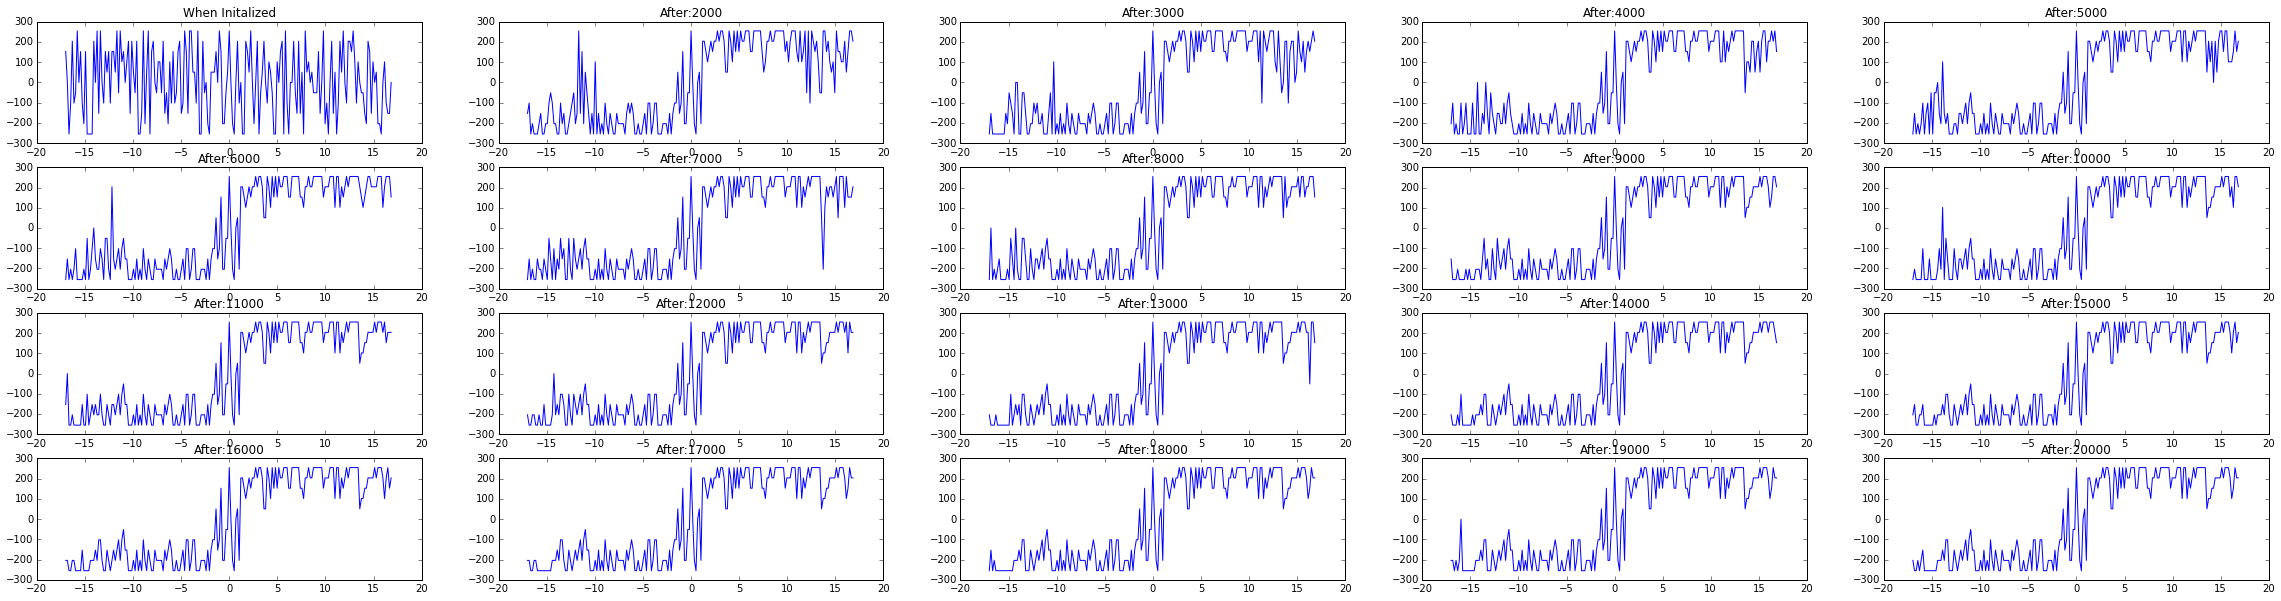

In [6]:
CalculateForSpecificLambda(0) 

### lambda 0.1

Episode :900
Total Episodes :19000


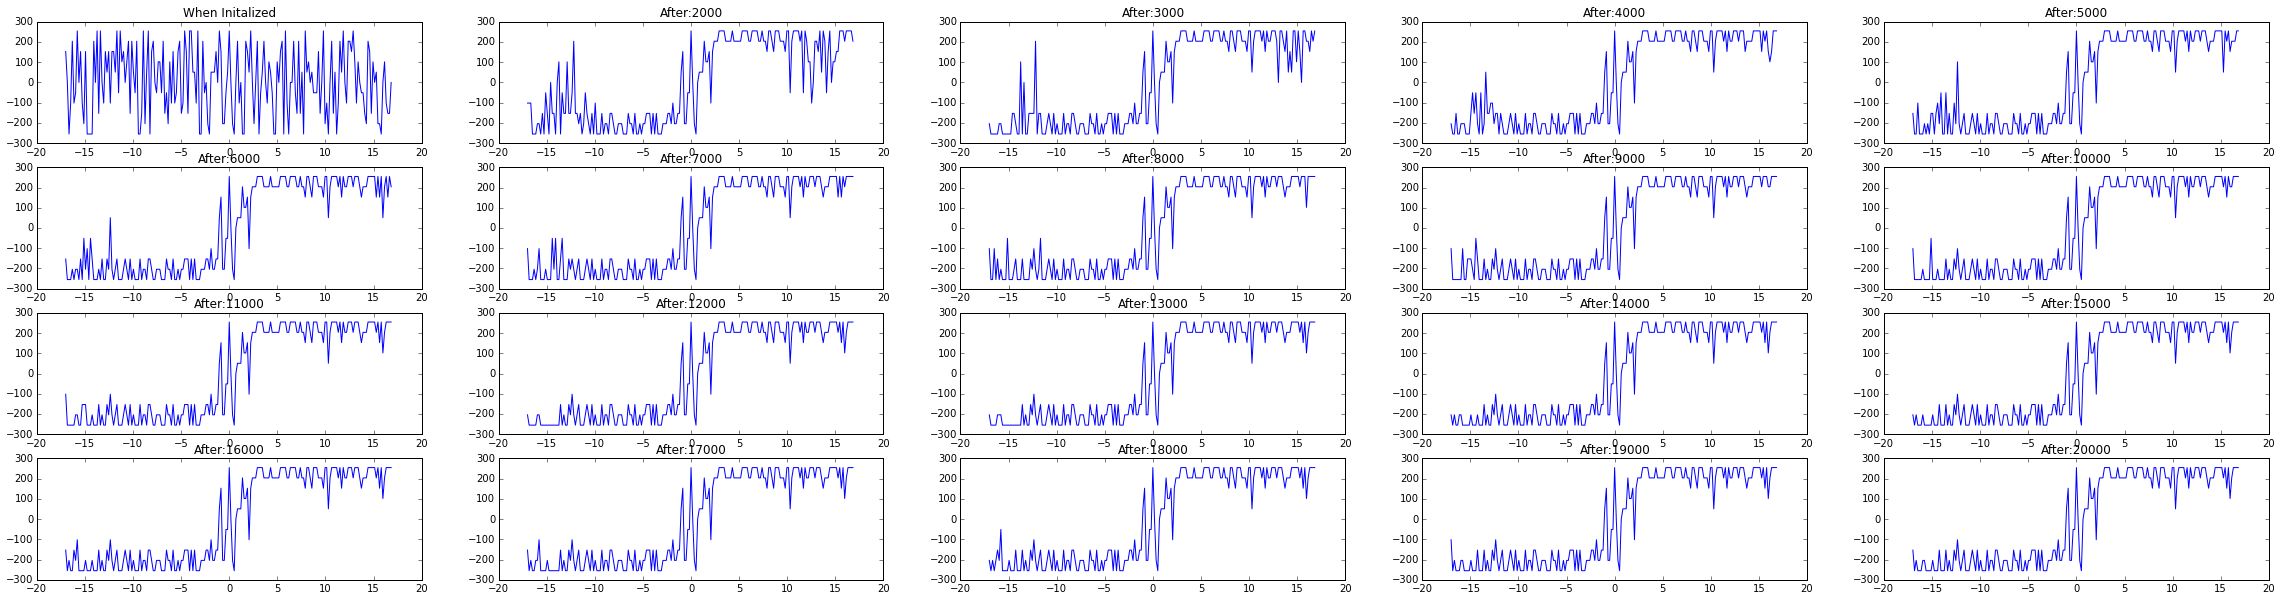

In [7]:
CalculateForSpecificLambda(0.1)   

### lambda 0.5

Episode :900
Total Episodes :19000


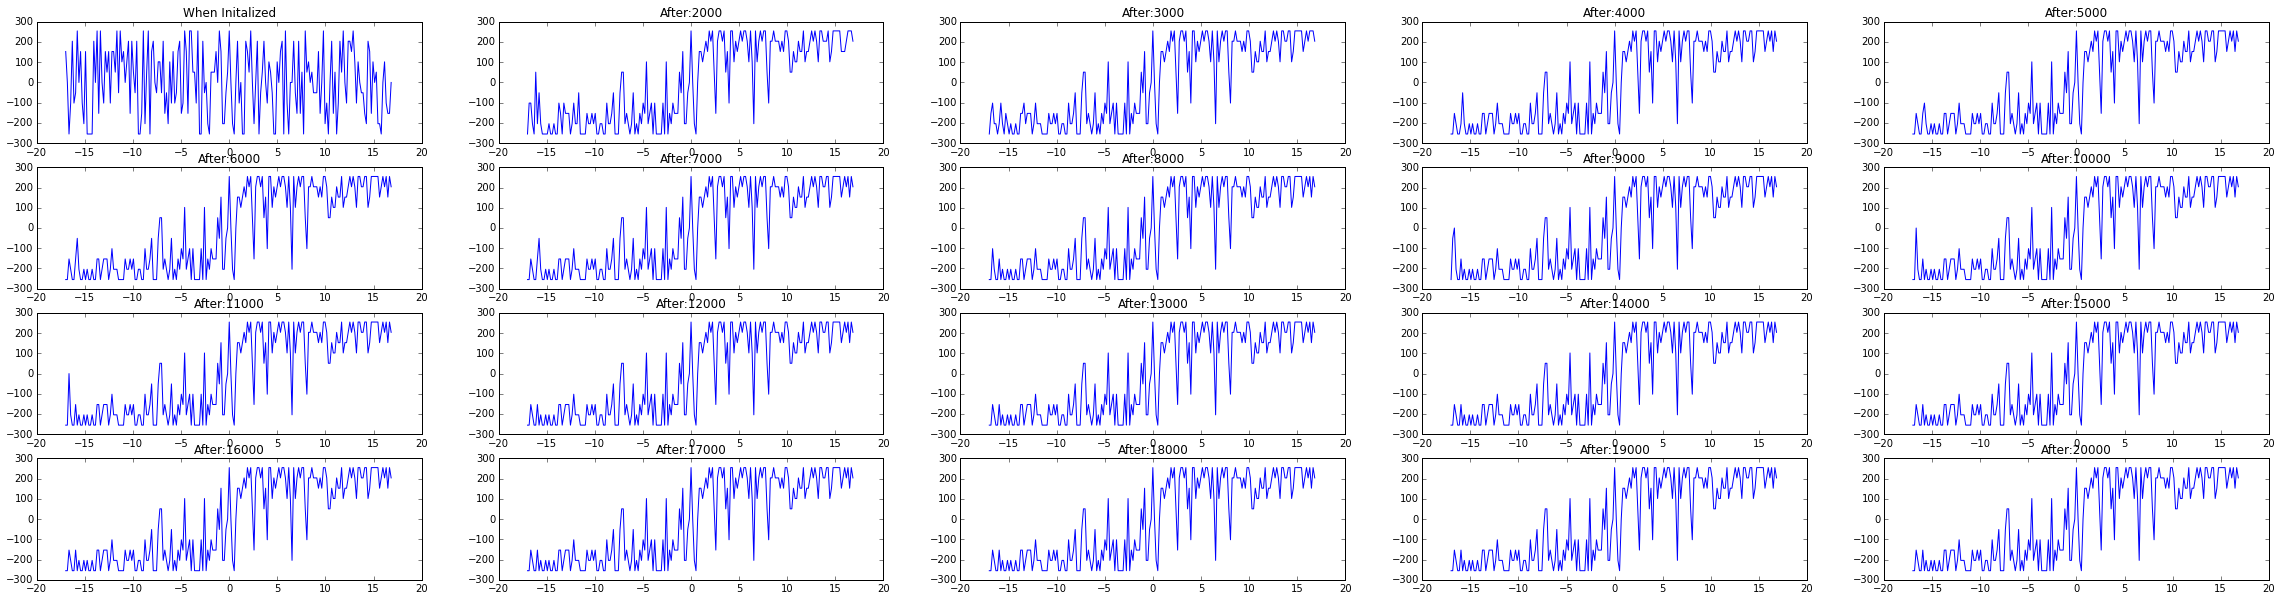

In [8]:
CalculateForSpecificLambda(0.5)

### lambda 0.7

Episode :900
Total Episodes :19000


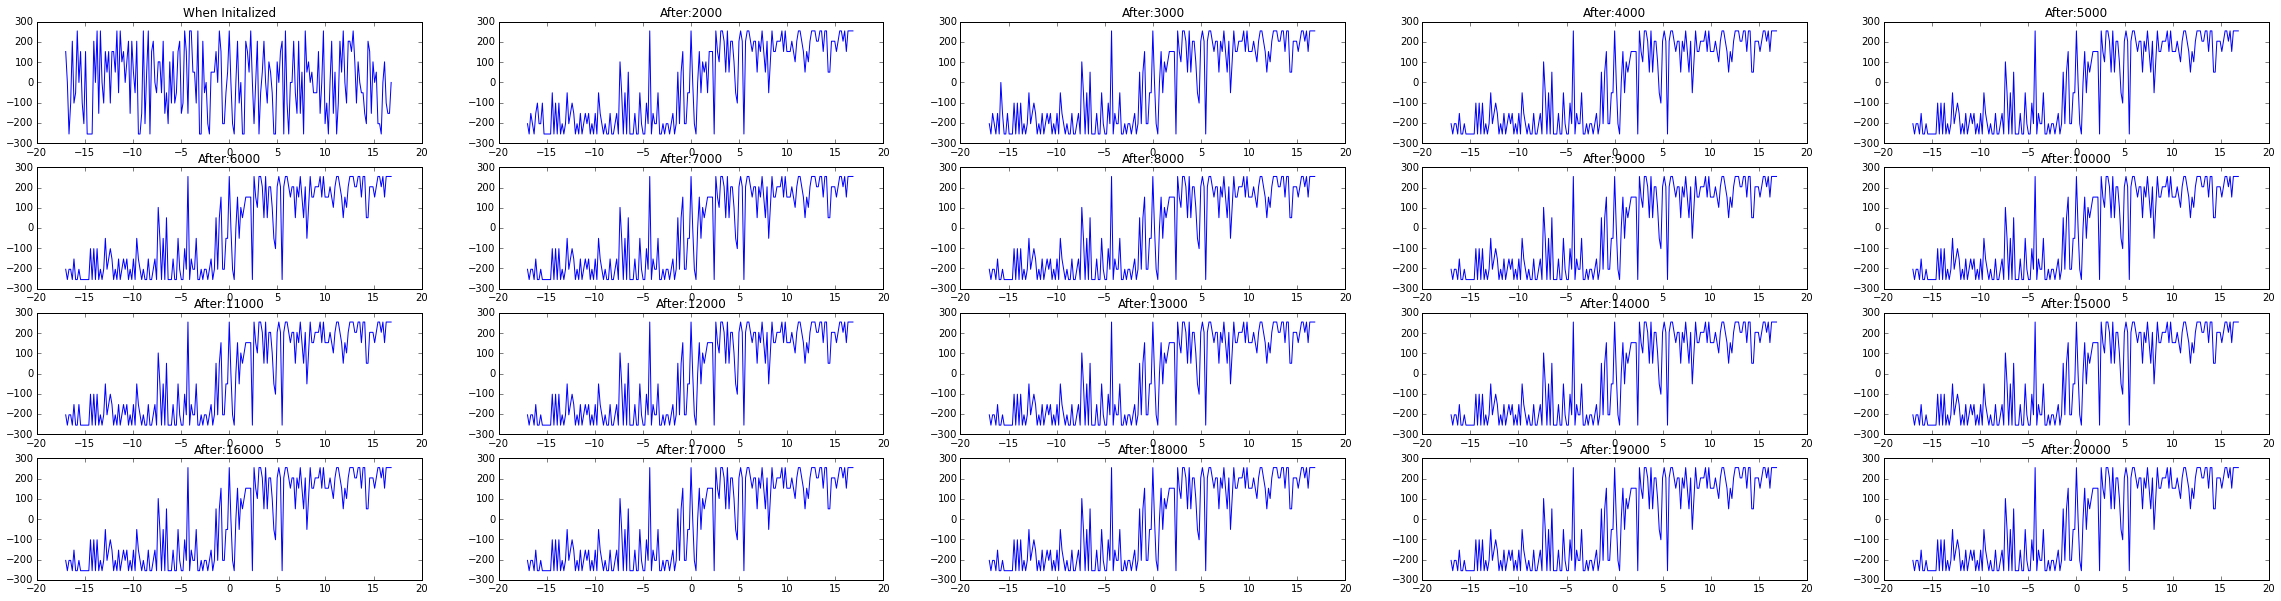

In [26]:
CalculateForSpecificLambda(0.7)

### 1000,000 Episode lambda 0.1
* We can see it's almost S signal which how it should be
* around 0 we can see two spikes in opposite direction I believe those two created due to no action in this state can get us to 0 so it move in the opossite direction to be able to reach the optimal state

Episode :999900


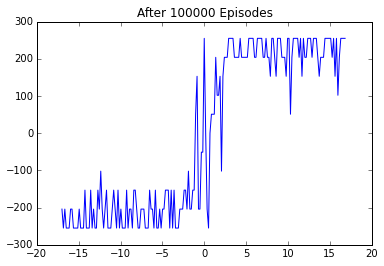

In [12]:
main = RL_Controller_Sarsa(lmbda=0.1,optimal_distance=30,actionscount=10,StatesCount=100)
main.Initalization()
main.PlaySarasa(1000000)
Draw(main,'After 100000 Episodes',plt)

In [13]:
for i in range (main.States.shape[0]):
    print 'Domain:{},Best Action:{},Happend:{}'.\
    format(main.States[i],main.actions[np.argmax(main.qsa[i])],main.n[i])

Domain:[-3000.   -17.],Best Action:-255.0,Happend:1643.0
Domain:[-17.         -16.82828283],Best Action:-204.0,Happend:10303.0
Domain:[-16.82828283 -16.65656566],Best Action:-255.0,Happend:10174.0
Domain:[-16.65656566 -16.48484848],Best Action:-204.0,Happend:212.0
Domain:[-16.48484848 -16.31313131],Best Action:-255.0,Happend:20329.0
Domain:[-16.31313131 -16.14141414],Best Action:-255.0,Happend:10353.0
Domain:[-16.14141414 -15.96969697],Best Action:-255.0,Happend:10259.0
Domain:[-15.96969697 -15.7979798 ],Best Action:-204.0,Happend:20563.0
Domain:[-15.7979798  -15.62626263],Best Action:-204.0,Happend:403.0
Domain:[-15.62626263 -15.45454545],Best Action:-255.0,Happend:319.0
Domain:[-15.45454545 -15.28282828],Best Action:-255.0,Happend:20798.0
Domain:[-15.28282828 -15.11111111],Best Action:-255.0,Happend:10530.0
Domain:[-15.11111111 -14.93939394],Best Action:-255.0,Happend:10556.0
Domain:[-14.93939394 -14.76767677],Best Action:-204.0,Happend:30349.0
Domain:[-14.76767677 -14.5959596 ],Best

# Sarsa With Linear Function Approximation Need More Debuging

In [18]:
from IPython.display import clear_output
class RL_Controller_LFA:
    
    def __init__(self,lmbda=0.1,optimal_distance=30,staticActionThreshould=1,actionscount=3,StatesCount=5,\
                 Exploration=0.1,loaddata=False):
        '''
        staticActionThreshould : when distance more or less than 3*std Robot will get static action
        ActionsCount : 1 for no action , rest divided by 2 to cover positive , negative
        StatesCount : at least 4 per Side
        '''
        self.lmbda =lmbda
        self.Exploration = Exploration
        self.ActionsCount=actionscount
        self.StatesCount= StatesCount
        self.actions= 0
        self.States=0
        self.std = np.round(np.std(np.arange(0,optimal_distance*2)))*staticActionThreshould
        self.AcceptedError = np.array((-1.0,1.0))*(0.03*optimal_distance)
        self.qsa=0
        self.OptimalDistance =30
        np.random.seed(1377)
        self.Robot = Robot()
        #====Sarsa Related ===#
        self.qsa=0
        self.n=0
        self.et=0
        self.Terminated=False
        
        #self.stats = 
    def GenerateActions(self):
        if self.ActionsCount%2==0:
            self.ActionsCount+=1
        if self.ActionsCount<3:
            self.ActionsCount=3
        lst =[]
        #fwd or bwd number of actions
        for i in range ((self.ActionsCount-1)/2 +1):
            if i==0:
                lst.append(i)
                continue
            lst = [-i]+lst
            lst.append(i)
        self.actions= (np.array(lst)/(max(lst)*1.0))*255
        
    def GenerateStats(self):
        lst=[]
        if (self.StatesCount-1)%2==0:
            self.StatesCount+=1
        if self.StatesCount<4:
            self.StatesCount=4
        for i in range(self.StatesCount):
            if i==0:
                lst.append(i)
                continue
            lst = [-i]+lst
            lst.append(i)
        lst = (np.array(lst)/(np.max(lst)*1.0))*self.std
        lstdomains=[]
        for i in range(len(lst)-1):
            lstdomains.append((lst[i],lst[i+1]))
        lstdomains = [(-3000,lst[0])] + lstdomains
        lstdomains.append((lst[len(lst)-1],3000))
        self.States = np.array(lstdomains)
        self.StatesCount = self.States.shape[0]
        
    def PrepareForSarsa(self):
        self.qsa =np.random.normal(size=(self.States.shape[0],self.actions.shape[0]))
        self.et = np.zeros((self.States.shape[0],self.actions.shape[0]))
        self.n = np.zeros(self.States.shape[0])
        self.n.fill(0)
        
    def Initalization(self):
        print '=====Initialization====='
        self.GenerateActions()
        self.GenerateStats()
        self.PrepareForSarsa()
        print """Lambda={},Exploration={},OptimalDistance={},Actions={},States={},Std={},Accepted Error={},
        Robot Distance={},Qsa={}""".\
        format(self.lmbda,self.Exploration,self.OptimalDistance,self.actions.shape,self.States.shape,self.std,\
               self.AcceptedError,self.Robot.distance,self.qsa.shape)
        
    def GetStateIndex(self,CurrentState):
        for i in range (self.States.shape[0]):
            if self.States[i,0]<=CurrentState<=self.States[i,1]:
                return i
            
    def Get_Value(self,crnstat,acc):
        return np.sum(self.ActiveFeatures(crnstat,acc)*self.qsa)
    
    def GetAction(self,crntstat,statindx):
        #Deterministic solution for state out of range to assure the Robot won't get lost
        if statindx==0:
            #print 'distance:{},statindx:{},state:{},action:{}'.format(self.Robot.distance, statindx,self.States[statindx],self.actions[len(self.actions)-1])
            return 0
        if statindx==len(self.States)-1:
            #print 'distance:{},statindx:{},state:{},action:{}'.format(self.Robot.distance,statindx,self.States[statindx],self.actions[0])
            return len(self.actions)-1
        #Exploration Precentage depend on how many specific state  visited
        if np.random.rand() <= 0.05:
            rnd = np.random.randint(len(self.actions))
            return rnd
        else:
            ls = map(lambda x : self.Get_Value(crntstat,x),range(0,len(self.actions)))
            return np.argmax(self.qsa[statindx])
        
    def Step(self,actnindx):
        self.Robot.Move(self.actions[actnindx])
        crntstat = self.GetCurrentState()
        return crntstat,self.GetStateIndex(crntstat),self.GetReward(crntstat)
    
    def GetCurrentState(self):
        return self.Robot.distance - self.OptimalDistance
    
    def GetReward(self,crntstat):
        #if crntstat<=self.States[0,1] or crntstat>= self.States[self.States.shape[0]-1,0]:
        #    return -1000
        if self.AcceptedError[0]<=crntstat<=self.AcceptedError[1]:
            self.Terminated=True
            return 1000;
        else:
            return crntstat if crntstat<0 else -1*crntstat
        
    def FixPosition(self):
        s = self.GetCurrentState()
        sindx = self.GetStateIndex(s)
        while (sindx==0 or sindx==len(self.States)-1):
            aindx=self.GetAction(0,sindx)
            __,sindx,__ = self.Step(aindx)
    
    def PlayLFA(self,nepisode,step_size=0.01):
        
        for i in range(nepisode):
            
            self.et.fill(0)
            self.Robot=Robot()
            self.FixPosition()
            #print self.Robot.distance
            self.Terminated=False
            
            #---Game Started -----#
            s = self.GetCurrentState()
            sindx = self.GetStateIndex(s)
            aindx = self.GetAction(s,sindx)
            iit=0
            while not self.Terminated:
                iit+=1
                s_p,s_pindx, R = self.Step(aindx)
                a_pindx = self.GetAction(s_p,s_pindx)
                #if i==3 :
                #    print 'dist={},new State = {},s_pindx={},Reward {},new Action = {}'\
                #    .format(self.Robot.distance, s_p,s_pindx,R,self.actions[a_pindx])
                #    if iit==100:
                #        self.Terminated=True
                if iit%100==0:
                    clear_output()
                    print iit,'Episode :',i
                if not self.Terminated:
                    qnext = self.Get_Value(s_p,a_pindx)
                else:
                    qnext=0
                delta = R + qnext-self.Get_Value(s,aindx)
                self.et = self.lmbda*self.et+self.ActiveFeatures(s,aindx)
                self.qsa = step_size * self.et * delta
                
                s = s_p
                sindx = s_pindx
                aindx = a_pindx

            if i%99==0:
                clear_output()
                print 'Episode :{}'.format(i)
                
        self.SaveModel(nepisode)
    
    def SaveModel(self,episods,name='qsa'):
        fname = '{},stc:{},ac:{},epi:{}.dat'.format(name,self.States.shape[0],self.actions.shape[0],episods)
        self.qsa.dump(fname)
        
    def LoadModel(self,episods,name='qsa'):
        fname = '{},stc:{},ac:{},epi:{}.dat'.format(name,self.States.shape[0],self.actions.shape[0],episods)
        self.qsa = np.load(fname)       
            
    def AddOverlap(self,overlap):
        self.States[1:,0] = self.States[1:,0]-((self.States[3,1]-self.States[3,0])/2)
    
    def ActiveFeatures(self,crntstat,actionindx):
        fv = np.zeros(self.qsa.shape)
        for i,__ in np.ndenumerate(fv):
            #print 'crnt:{},MA:{},B:{},E:{},A:{}'.\
            #format(crntstat,action,self.States[i[0]][0],self.States[i[0]][1],i[1])
            if (self.States[i[0]][0] <= crntstat<=self.States[i[0]][1]) and actionindx == i[1]:
                fv[i]=1
        return fv

In [ ]:
def CalculateForSpecificLambda(lmbda):
    fig = plt.figure(1,figsize=(40, 10))
    #Initialization
    main = RL_Controller_LFA(lmbda=lmbda,optimal_distance=30,actionscount=10,StatesCount=100)
    main.Initalization()
    plt.subplot(2,5,1)
    Draw(main,'When Initalized',plt)
    episodesperloop=1000
    for i in range (1,10):
        main.PlaySarasa(episodesperloop)
        print 'Total Episodes :{}'.format(i*episodesperloop)
        plt.subplot(2,5,i+1)
        Draw(main,'After:{}'.format((i+1)*episodesperloop),plt)

    plt.show() 

=====Initialization=====
Lambda=0.1,Exploration=0.1,OptimalDistance=30,Actions=(11,),States=(200, 2),Std=17.0,Accepted Error=[-0.9  0.9],
        Robot Distance=54,Qsa=(200, 11)


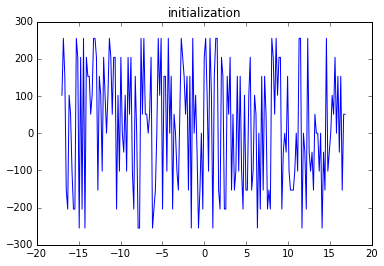

In [19]:
main = RL_Controller_LFA(optimal_distance=30,actionscount=10,StatesCount=100)
main.Initalization()
Draw(main,'initialization',plt)

6100 Episode : 9


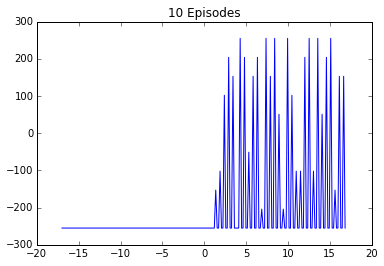

In [20]:
main.PlayLFA(10)
Draw(main,'10 Episodes',plt)

# Problems 
* The Accepted error is 3% so if the optimal distance is 1000 that's mean 970 - 1030 considered as accepted areas.

* Training Should be in Optimal area (by optimal I mean the robot shouldn't rotate, or irrationaly move from state to another like in changing environment)